In [19]:
import numpy as np
import gym
from typing import List
import matplotlib.pyplot as plt

In [20]:
# Usage example with OpenAI Gym environment
# Create the FrozenLake environment
env = gym.make("FrozenLake-v1", is_slippery=False)

# Q_final = edited_speedy_double_q_learning(env)
# _plot_evaluation()
# print("Final Q-Table for A:")
# print(Q_final)

In [21]:
lake_map=env.desc
frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
# print(frozen_lake_binary)
hole_indeces = np.where(frozen_lake_binary==0)[0]
print(hole_indeces)


[ 5  7 11 12 15]


The first total_time_steps reached to 1 is  4699
The length is   6.0


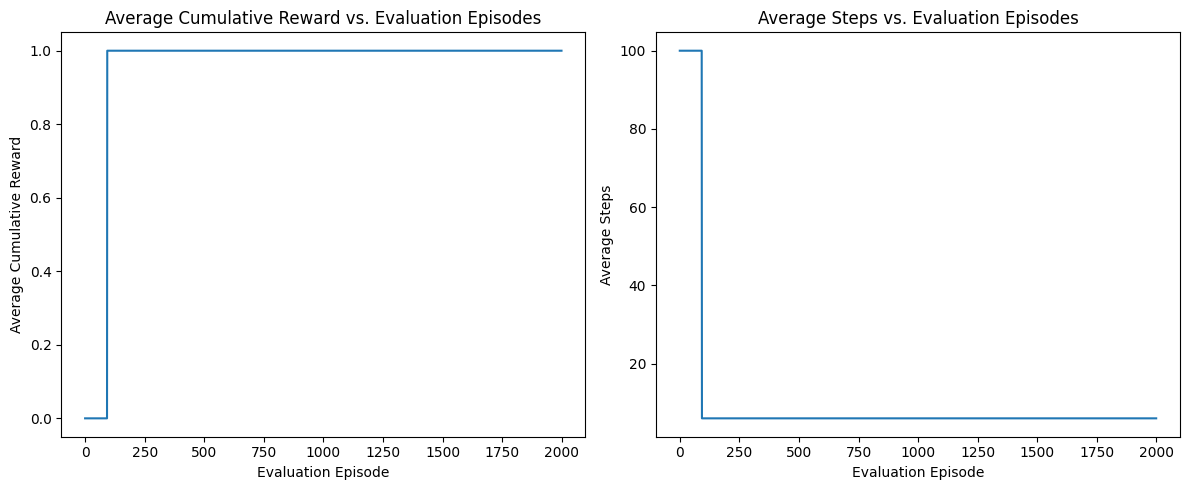

Final Q-Table for A:
[[0.15034294 0.42738863 0.06637646 0.16207639]
 [0.17210333 0.         0.08954693 0.02597996]
 [0.01980556 0.53224144 0.00128577 0.02564852]
 [0.05317278 0.         0.         0.        ]
 [0.32294629 0.5554517  0.         0.18059105]
 [0.         0.         0.         0.        ]
 [0.         0.73135529 0.         0.07026215]
 [0.         0.         0.         0.        ]
 [0.47158375 0.         0.77067543 0.34139583]
 [0.47566142 0.85983435 0.79295057 0.        ]
 [0.57661792 0.92337752 0.         0.4286462 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.79027751 0.93458921 0.71058129]
 [0.79360518 0.88747084 0.98033812 0.82097822]
 [0.         0.         0.         0.        ]]


In [29]:
def evaluate_policy(env, q_table, episodes=10):
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0

    for _ in range(episodes):
        state = env.reset()[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done or truncated):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps >200:
                episode_reward = 0
                print("eval break")
                break

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length


def plot_metrics(rewards: List[float], lengths: List[int]):
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Average Cumulative Reward vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")

    plt.subplot(1, 2, 2)
    plt.plot(lengths)
    plt.title("Average Steps vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.tight_layout()
    plt.show()


def initialize_Q_values(state_space, action_space):
    """Initialize Q-values for A and B with all zeros, except terminal states set to zero."""
    # Q_A = np.random.rand(state_space, action_space)
    # Q_B = np.random.rand(state_space, action_space)
    Q_A = np.zeros((state_space, action_space))
    Q_B = np.zeros((state_space, action_space))
    # Assume terminal state is the last state for simplicity
    Q_A[-1, :] = 0
    Q_B[-1, :] = 0
    return Q_A, Q_B

def edited_speedy_double_q_learning(env, epsilon=1, min_epsilon=0.1, epsilon_decay=0.9999, T=100000, gamma=0.99, eval_interval=50, eval_episodes=1):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    Q_A, Q_B = initialize_Q_values(state_space, action_space)
    Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

    N_A = np.zeros((state_space, action_space))
    N_B = np.zeros((state_space, action_space))

    evaluation_rewards = []
    evaluation_lengths = []
    evaluation_steps = []

    k_A = k_B = 0
    alpha_A = alpha_B = 1

    state = env.reset()[0]
    t = 0


    # Create a mask that is True for rows we want to consider
    mask = np.ones(len(N_A), dtype=bool)
    mask[hole_indeces] = False

    first = True
    while t <= T:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            combined_Q = (Q_A[state, :] + Q_B[state, :]) / 2
            action = np.argmax(combined_Q)

        next_state, reward, done, truncated, info = env.step(action)

        if np.random.rand() < 0.5:  # Update Q_A
            eta = 1 / (N_A[state, action] + 1)
            a_star = np.argmax(Q_A_minus_1[next_state, :])
            a_plus = np.argmax(Q_A[next_state, :])

            T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (reward + gamma * Q_B_minus_1[next_state, a_star])
            T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (reward + gamma * Q_B[next_state, a_plus])

            Q_A_minus_1[state, action] = Q_A[state, action]
            Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
            N_A[state, action] += 1
        else:  # Update Q_B
            eta = 1 / (N_B[state, action] + 1)
            a_star = np.argmax(Q_B_minus_1[next_state, :])
            a_plus = np.argmax(Q_B[next_state, :])
            T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                        reward + gamma * Q_A_minus_1[next_state, a_star])
            T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (reward + gamma * Q_A[next_state, a_plus])

            Q_B_minus_1[state, action] = Q_B[state, action]
            Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                        k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
            N_B[state, action] += 1

        state = next_state

        # Update counters and learning rates if needed
        if np.min(N_A[mask]) > 0:
            k_A += 1
            alpha_A = 1 / (k_A + 1)
            N_A.fill(0)  # Reset visit counts for A
        if np.min(N_B[mask]) > 0:
            k_B += 1
            alpha_B = 1 / (k_B + 1)
            N_B.fill(0)  # Reset visit counts for B

        if (t + 1) % eval_interval == 0:
            avg_reward, avg_length = evaluate_policy(env, (Q_A + Q_B) / 2, eval_episodes)
            if first and avg_reward:
                first = False
                print("The first total_time_steps reached to 1 is ", t)
                print("The length is  ", avg_length) 
            evaluation_rewards.append(avg_reward)
            evaluation_lengths.append(avg_length)
            evaluation_steps.append(t + 1)
            # print(f"Evaluation at step {t + 1}: Avg Reward = {avg_reward}, Avg Length = {avg_length}")
        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon
        t += 1
        if done:
            state = env.reset()[0]
    plot_metrics(evaluation_rewards, evaluation_lengths)
    return Q_A


Q_final = edited_speedy_double_q_learning(env)
print("Final Q-Table for A:")
print(Q_final)

Evaluation at step 5000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 10000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 15000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 20000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 25000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 30000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 35000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 40000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 45000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 50000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 55000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 60000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 65000: Avg Reward = 0.0, Avg Length = 100.0
Evaluation at step 70000: Avg Reward = 1.0, Avg Length = 6.0
Evaluation at step 75000: Avg Reward = 1.0, Avg Length = 6.0
Evaluation at step 80000: Avg Reward = 1.0, Avg Length = 6.0

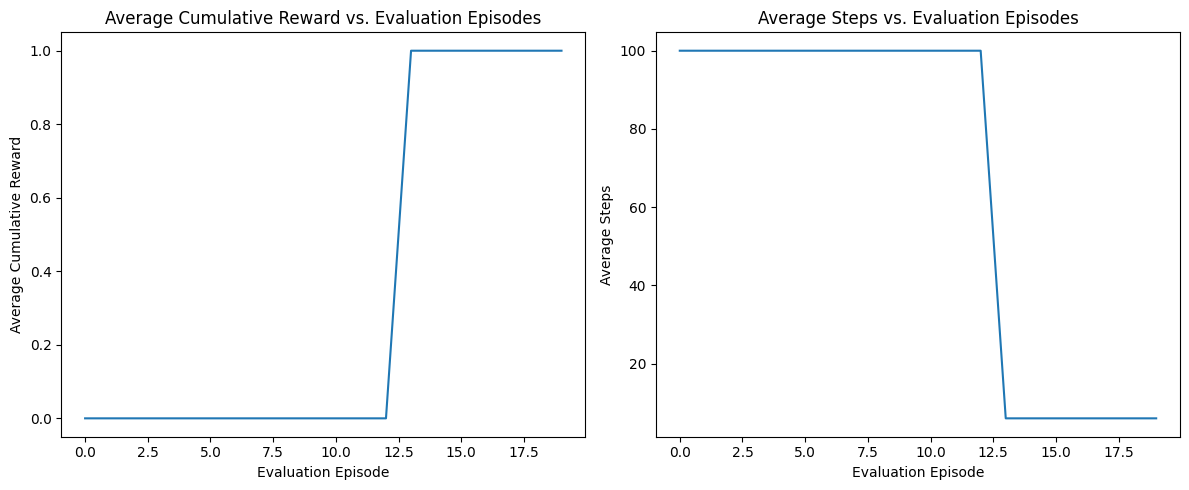

Final Q-Table for A:
[[0.86913093 0.88369014 0.86286188 0.86808453]
 [0.87055625 0.8008347  0.83259033 0.85235047]
 [0.86023311 0.67693128 0.73891118 0.83281626]
 [0.81202564 0.65244657 0.71855088 0.51137241]
 [0.88459096 0.88675379 0.80696907 0.87120006]
 [0.64620805 0.22590625 0.4230355  0.23001927]
 [0.78408545 0.76997393 0.71712071 0.85661546]
 [0.19787827 0.96350494 0.38494718 0.71116361]
 [0.88283566 0.62518704 0.91917568 0.88406431]
 [0.88912979 0.96364587 0.8954009  0.80718958]
 [0.85831838 0.9650663  0.14629946 0.72879117]
 [0.0595544  0.7824912  0.60578303 0.14277147]
 [0.22902702 0.5349237  0.1076022  0.04822217]
 [0.62618473 0.94707101 0.98675669 0.92308276]
 [0.9349077  0.97522403 0.99976447 0.91709924]
 [0.         0.         0.         0.        ]]


In [12]:
Q_final = edited_speedy_double_q_learning(env)
print("Final Q-Table for A:")
print(Q_final)